<a href="https://colab.research.google.com/github/KiloDragon/HWinn/blob/main/HW_att3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install farm-haystack[colab,preprocessing,inference,elasticsearch,metrics] --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.0/856.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 82

In [2]:
%%bash

wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
chown -R daemon:daemon elasticsearch-7.9.2

In [3]:
%%bash --bg

sudo -u daemon -- elasticsearch-7.9.2/bin/elasticsearch


In [4]:
import time
#Нужно подожать 30 сек для разворачивания сервера
time.sleep(30)

Загрузим Squad 2 датасет

In [5]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2023-11-09 19:50:05--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  71.1MB/s    in 0.6s    

2023-11-09 19:50:06 (71.1 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2023-11-09 19:50:06--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       

Развернем MLFlow для оценки и сравнения моделей


In [6]:
import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

get_ipython().system_raw("mlflow ui --port 5000 &")

from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN = "2Xvl11WR3YEN9qKfsZg3XHs4GRG_52WyMRF3zX6JJ1Su3TdkR"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://22ba-35-196-55-72.ngrok-free.app


Подготовим датасет к оценке

In [7]:
import tempfile
from pathlib import Path
from haystack.nodes import PreProcessor
from haystack.document_stores import InMemoryDocumentStore

document_store = InMemoryDocumentStore(use_bm25=True)

label_preprocessor = PreProcessor(
    split_length=200,
    split_overlap=0,
    split_respect_sentence_boundary=False,
    clean_empty_lines=False,
    clean_whitespace=False,
)


document_store.add_eval_data(
    filename="dev-v2.0.json",
    doc_index=document_store.index,
    label_index=document_store.label_index,
    preprocessor=label_preprocessor,
)


evaluation_set_labels = document_store.get_all_labels_aggregated(drop_negative_labels=True, drop_no_answers=True)


docs = document_store.get_all_documents()
temp_dir = tempfile.TemporaryDirectory()
file_paths = []
for doc in docs:
    file_name = doc.id + ".txt"
    file_path = Path(temp_dir.name) / file_name
    file_paths.append(file_path)
    with open(file_path, "w") as f:
        f.write(doc.content)
file_metas = [d.meta for d in docs]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Updating BM25 representation...: 100%|██████████| 1304/1304 [00:00<00:00, 10465.56 docs/s]


Сделаем пайплайн

In [8]:
from haystack.nodes import BM25Retriever, EmbeddingRetriever, FARMReader, TextConverter
from haystack.pipelines import Pipeline
from haystack.document_stores import ElasticsearchDocumentStore

def create_pipelines(document_store, preprocessor, retriever, reader):
    query_pipeline = Pipeline()
    query_pipeline.add_node(component=retriever, inputs=["Query"], name="Retriever")
    query_pipeline.add_node(component=reader, inputs=["Retriever"], name="Reader")
    index_pipeline = Pipeline()
    index_pipeline.add_node(component=TextConverter(), inputs=["File"], name="TextConverter")
    index_pipeline.add_node(component=preprocessor, inputs=["TextConverter"], name="Preprocessor")
    index_pipeline.add_node(component=retriever, inputs=["Preprocessor"], name="Retriever")
    index_pipeline.add_node(component=document_store, inputs=["Retriever"], name="DocumentStore")
    return query_pipeline, index_pipeline

Создадим эксперимент в MLFlow

In [9]:
import os
EXPERIMENT_NAME = "HW_att"
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")

Для первой оценки выберем sparce retriever

In [10]:
document_store_f = ElasticsearchDocumentStore(host=host, index="sparse_index", recreate_index=True)
preprocessor = PreProcessor(
    split_length=200,
    split_overlap=0,
    split_respect_sentence_boundary=False,
    clean_empty_lines=False,
    clean_whitespace=False,
)
es_retriever = BM25Retriever(document_store=document_store_f)
reader = FARMReader("deepset/roberta-base-squad2", top_k=3,use_gpu=True, batch_size=8)
query_pipeline, index_pipeline = create_pipelines(document_store_f, preprocessor, es_retriever, reader)

Посмотрим метрики на MLFlow и запустим еще расчет

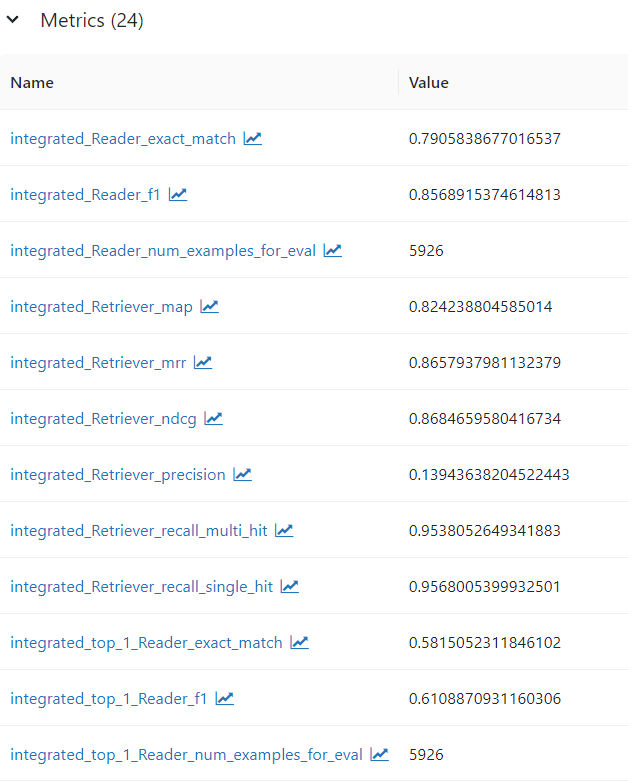

Запустим embeded retriever

In [ ]:
document_store_e = ElasticsearchDocumentStore(host=host, index="dense_index", recreate_index=True)
emb_retriever = EmbeddingRetriever(
    document_store=document_store_e,
    model_format="sentence_transformers",
    embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1",
    batch_size=8,
)
query_pipeline_emb, index_pipeline_emb = create_pipelines(document_store_e, preprocessor, emb_retriever, reader)

dense_eval_result = Pipeline.execute_eval_run(
    index_pipeline=index_pipeline_emb,
    query_pipeline=query_pipeline_emb,
    evaluation_set_labels=evaluation_set_labels,
    corpus_file_paths=file_paths,
    corpus_file_metas=file_metas,
    experiment_name=EXPERIMENT_NAME,
    experiment_run_name="embedding",
    corpus_meta={"name": "dev-v2.0.json"},
    evaluation_set_meta={"name": "dev-v2.0.json"},
    pipeline_meta={"name": "embedding-pipeline"},
    add_isolated_node_eval=True,
    experiment_tracking_tool="mlflow",
    experiment_tracking_uri=ngrok_tunnel.public_url,
    reuse_index=True,
    answer_scope="context",
)

Посмотрим на метрики. И сравнение
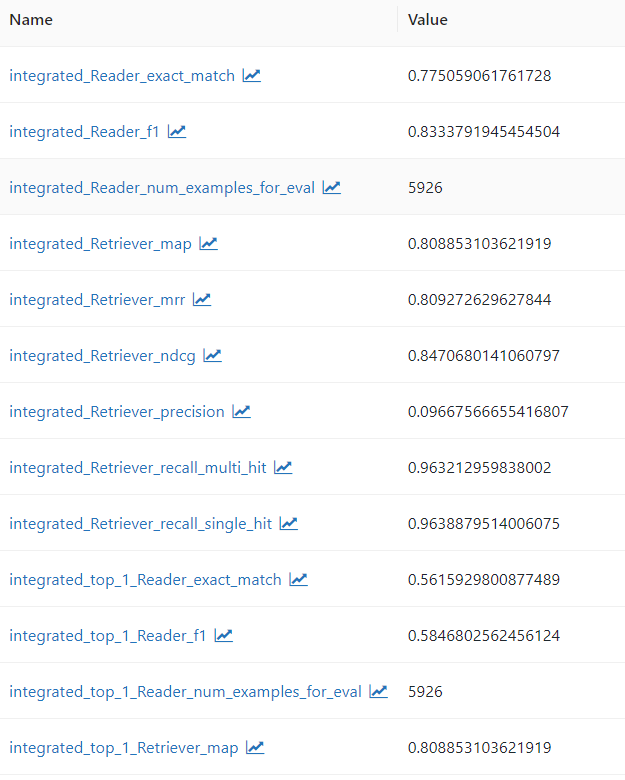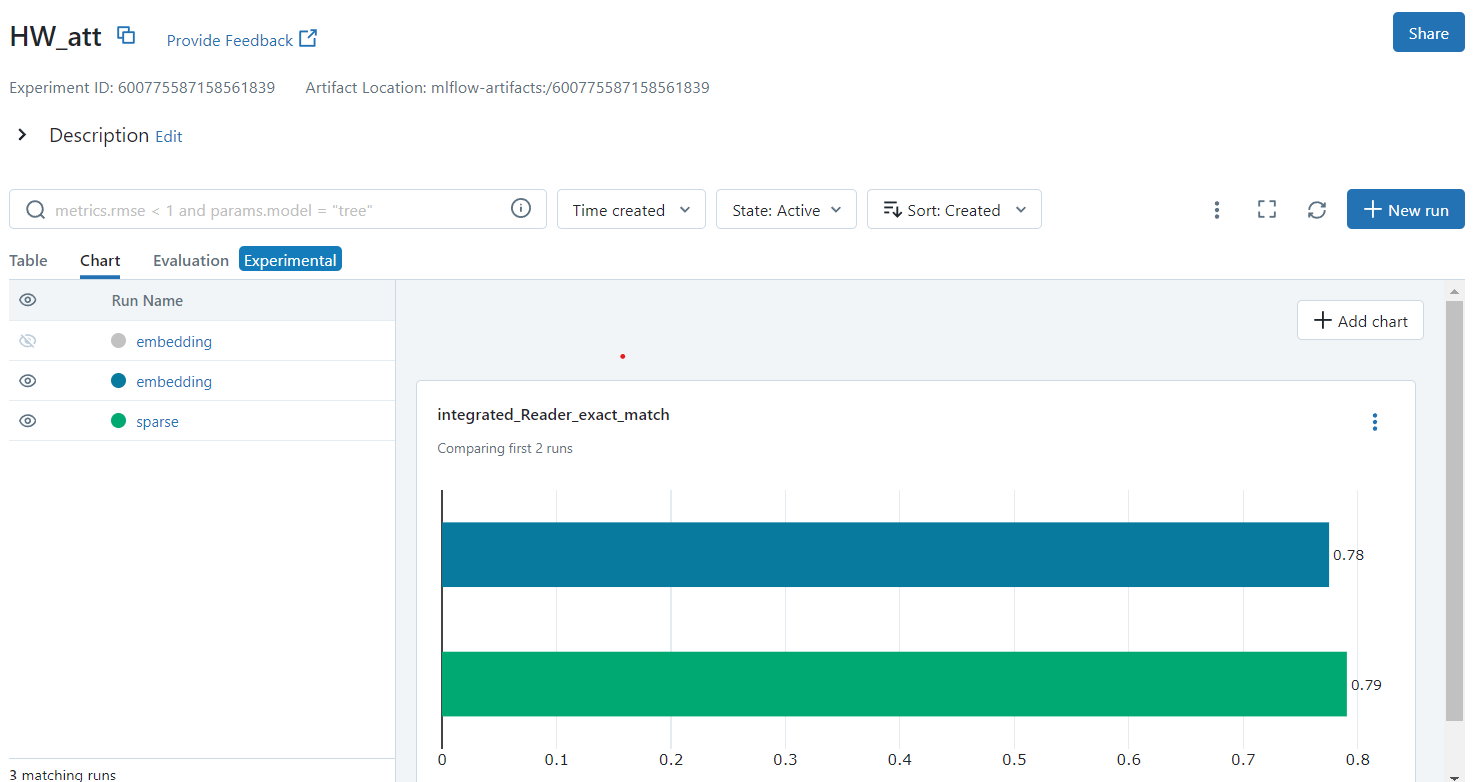

На данных резултаты примерно одинаковые, но sparce чуть лучше и быстрее. Теперь запустим модель и заддим несколько вопросов

In [11]:
from haystack.pipelines import ExtractiveQAPipeline
from haystack.utils import print_answers
from haystack.pipelines.standard_pipelines import TextIndexingPipeline


reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)
retriever = BM25Retriever(document_store=document_store)
pipe = ExtractiveQAPipeline(reader, retriever)
prediction = pipe.run(
    query='What types of waves do seismologists use to image the interior of the Earth?', params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 1}}
)

print_answers(prediction, details="minimum")

Inferencing Samples: 100%|██████████| 1/1 [00:12<00:00, 12.54s/ Batches]

('Query: What types of waves do seismologists use to image the interior of the '
 'Earth?')
'Answers:'
[   {   'answer': 'seismic waves',
        'context': 'Seismologists can use the arrival times of seismic waves '
                   'in reverse to image the interior of the Earth. Early '
                   'advances in this field showed the existe'}]
